# Ising model simulation with Monte Carlo method

In [70]:
import os
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Circle

In [22]:
fdir = './Documentation/src/images/'
ffmt = 'pdf'
fdpi = 150

axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15
sc = 10

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': False,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Characteristic parameters of the system

In [23]:
k_B = 1.380648e-23    # Boltzmann constant
J = 5e-22             # Arbitrary J
T = 200               # Temperature
beta = 1 / (k_B * T)  # Characteristic value

## Random +1 or -1

In [105]:
def get_random_spins(size):
  return np.sign(np.random.random(size) - 0.5)

# Ising model simulation on 1D lattice

In [73]:
# Number of spins, situated on the 1D lattice
N_spin_1D = 300

offset_1D = 2000

## 1.: Randomly choose directions for starting position of the spins

In [74]:
def plot_1D(spins):
  
  fig, ax = plt.subplots(1, 1, figsize=(15,8))
  
  p = 0 # Number of + spins
  n = 0 # Number of - spins
  
  for i, s in enumerate(spins):
    if s > 0: ax.scatter(i, s, color='red', s=sc**2); p+=1
    elif s < 0: ax.scatter(i, s, color='blue', s=sc**2); n+=1
  
  ax.set_xlabel('Spins [n]', fontsize=axislabelsize)
  ax.set_ylabel('Initial values of Ising spins (+/-)', fontsize=axislabelsize)
  ax.tick_params(axis='both', which='major', labelsize=axisticksize)

  p_label = 'Number of positive spins: {0}'.format(p)
  n_label = 'Number of negative spins: {0}'.format(n)
  legend_elements = [Line2D([0], [0], marker='o', color='white', markerfacecolor='red',
                            markersize=10, label=p_label),
                     Line2D([0], [0], marker='o', color='white', markerfacecolor='blue',
                            markersize=10, label=n_label)]

  ax.legend(handles=legend_elements, loc='best',
            fontsize=axislegendsize)

  plt.show()

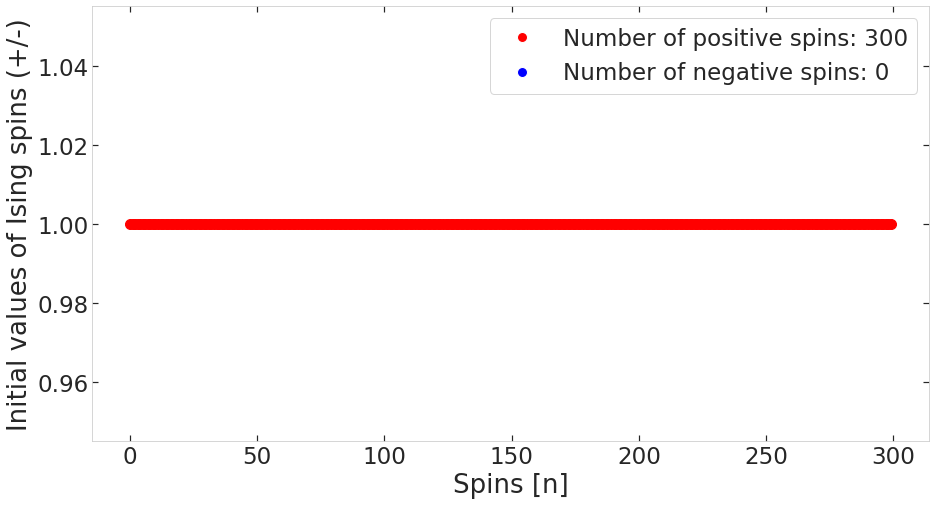

In [75]:
# The current positions of the spins
#spins_1D = np.array([choose_sign() for i in range(0, N_spin)])
spins_1D = np.ones((N_spin_1D))
plot_1D(spins=spins_1D)

## 2.: $E_{tot.}$ energy of the current state

In [76]:
def E_1D(spins):
  
  E = 0
  for i in range(spins.size-1):
    E += spins[i] * spins[i+1]

  return E * J

## 3.: Step with the simulation

In [77]:
def simulation_step_1D(spins,
                       beta, steps=1000):

  # Chronologies for reached energy levels' indeces and actual energies in order
  spin_chrono = np.zeros((steps+1, spins.size), dtype='int')
  E_chrono = np.zeros((steps+1))
  total_M = np.zeros((steps+1))

  # Initial condition of the system
  spin_chrono[0] = spins
  E_chrono[0] = E_1D(spins=spins)
  total_M[0] = spins.sum()/len(spins)

  for step_i in range(0, steps):
    # Choose a random Ising spin from the pool at the start of every step
    rand_i = np.random.choice(spins.size)

    # Rotate it to check the energy difference
    spins_new = spins
    spins_new[rand_i] *= -1

    # Calculate energy difference between the jump's origin and end points
    E_1 = E_1D(spins=spins)
    E_2 = E_1D(spins=spins_new)
    delta_E = E_2 - E_1

    # Update chronology of reached energies indeces
    # If delta_E <= 0, then execute the flip
    if(delta_E < 0):
      spin_chrono[step_i+1] = spins_new
      spins = spins_new
      # Update chronology of actual reached energy levels
      energy_chronology[step_i+1] = E_2

    if(delta_E == 0):
      if(np.random.random() < 0.5):
        spin_chrono[step_i+1] = spins_new
        spins = spins_new
        # Update chronology of actual reached energy levels
        E_chrono[step_i+1] = E_2

      else:
        spin_chrono[step_i+1] = spins
        # Update chronology of actual reached energy levels
        E_chrono[step_i+1] = E_1

    # If delta_E > 0, choose a random number X, between 0 and 1
    # If X < e^(-beta * delta_E), then execute the spin flip
    # If not, then leave the spins' state untouched and continue with the next step
    else:
      if(np.random.random() < np.exp(- beta * delta_E)):
        spin_chrono[step_i+1] = spins_new
        spins = spins_new
        # Update chronology of actual reached energy levels
        E_chrono[step_i+1] = E_2

      else:
        spin_chrono[step_i+1] = spins
        # Update chronology of actual reached energy levels
        E_chrono[step_i+1] = E_1

    # Update the total magnetization chronology
    total_M[step_i] = spins.sum()/len(spins)

  return spin_chrono, E_chrono, total_M, spins

In [83]:
def plot_quantity(indeces, quantity, offset,
                  label):

  fig, ax = plt.subplots(1, 1, figsize=(10,10))
        
  ax.axvline(x=offset,
             color='black', linestyle='--', label='Start of equilibrium')
  ax.axhline(y=0, color='green', label='Equilibrium')

  ax.plot(indeces, quantity,
          c='red', label='{0} of the Spin-state'.format(label))

  ax.set_title('{0} at $T =${1:.2f} K'.format(label, 1 / (beta * k_B)),
               fontsize=axistitlesize, fontweight='bold', pad=30)

  ax.set_xlabel('Time [$N \\cdot \\tau$]',
                fontsize=axislabelsize, fontweight='bold')
  ax.set_ylabel('Total {}'.format(label.lower()),
                fontsize=axislabelsize, fontweight='bold')

  ax.tick_params(axis='both', which='major', labelsize=axisticksize)
  ax.yaxis.get_offset_text().set_fontsize(15)

  ax.legend(loc='upper right', fontsize=axislegendsize)

  plt.show()

## Run the simulation with initial conditions

In [79]:
steps_1D = 5000

# Run the simulation
spin_chrono, E_chrono, total_M, spins_1D_new = \
                  simulation_step_1D(spins=spins_1D.copy(),
                                     beta=beta,
                                     steps=steps_1D)

indeces_1D = np.arange(steps_1D+1)

## Final spin-state

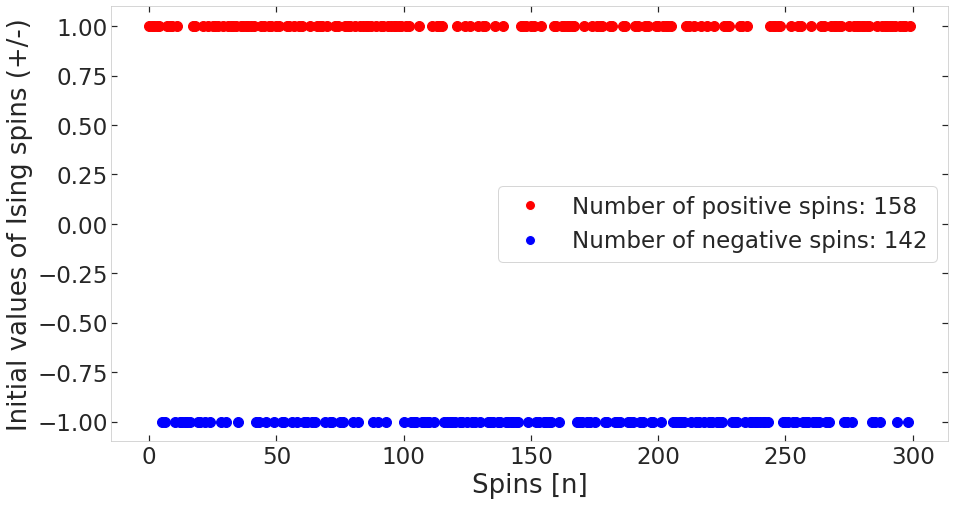

In [80]:
plot_1D(spins=spins_1D_new)

## Energy propagation of the system

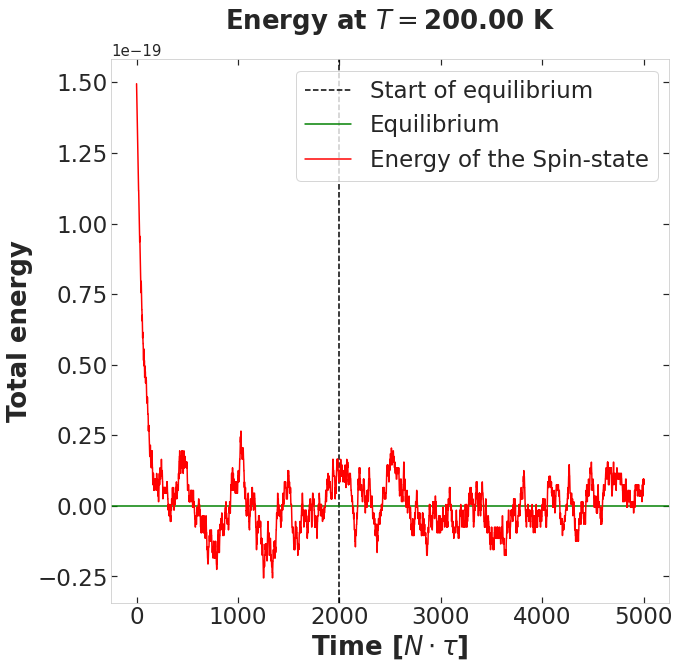

In [84]:
plot_quantity(indeces=indeces_1D, quantity=E_chrono, offset=offset_1D,
              label='Energy')

## Magnetization of the system

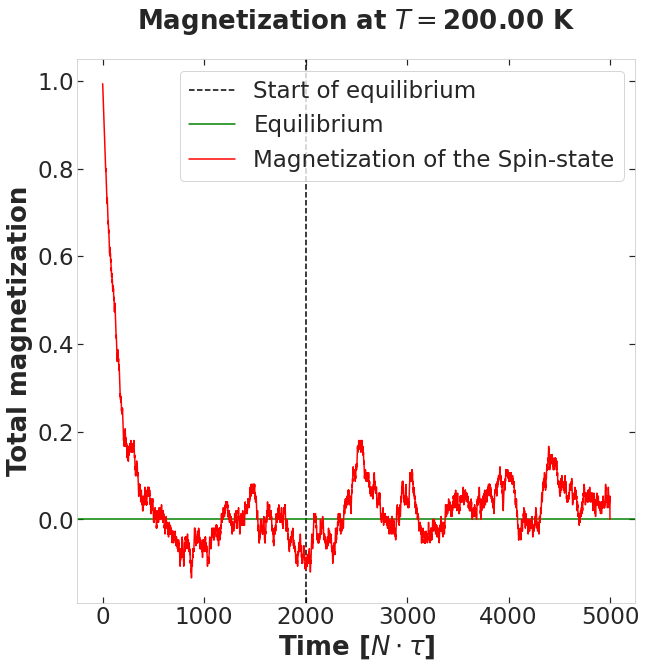

In [86]:
plot_quantity(indeces=indeces_1D, quantity=total_M, offset=offset_1D,
              label='Magnetization')

# Ising model simulation on 2D lattice

In [106]:
# Number of spins in a row at the 2D case
N_spin_2D = 30

start_offset_2D = 2000

In [108]:
# The current positions of the spins
spins_2D = choose_sign_2D(size=(N_spin_2D,N_spin_2D))

## 1.: Randomly choose directions for starting position of the spins

## 2.1.: $E_{tot.}$ energy of the current state

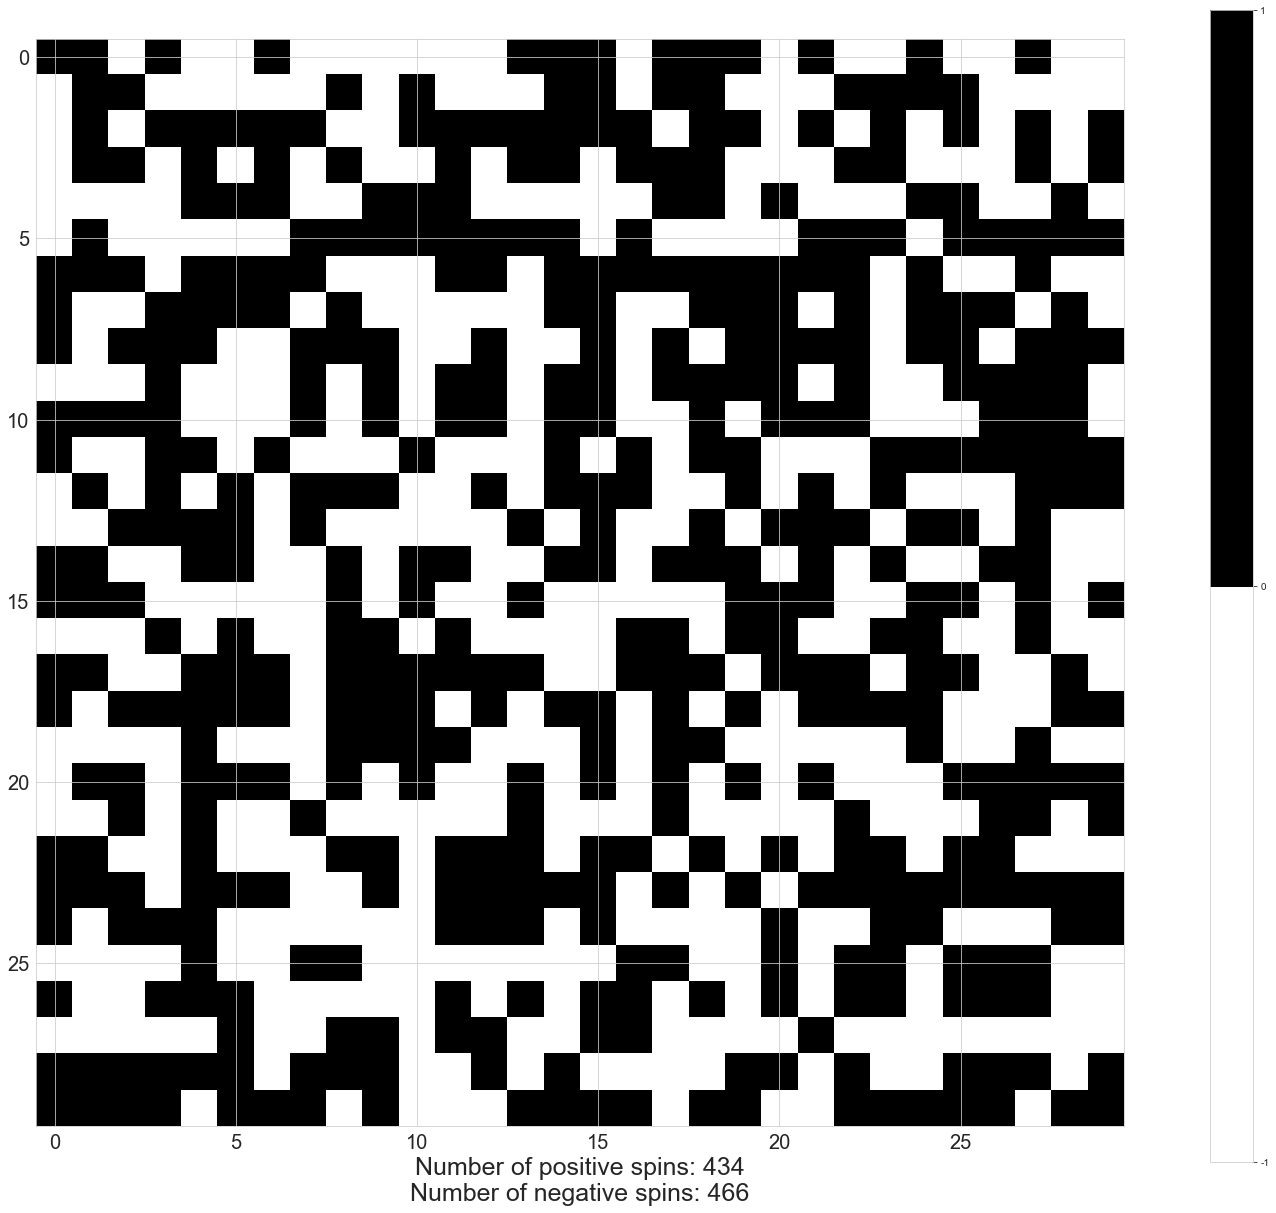

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

spin_image = axes.imshow(Spins_2D, cmap='Greys_r')

axes.set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                      len(Spins_negative_2D)),
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.show()

In [77]:
def E_Initial_2D(Spins):
    
    E = 0
    
    for i in range(0, N_spin_2D-2):
        for j in range(0, N_spin_2D-2):
            
            try:
                E += Spins[i][j] * Spins[i+1][j] + Spins[i][j] * Spins[i][j+1] + Spins[i][j] * Spins[i+1][j+1]
            except:
                pass
            else:
                continue
    
    return E * J

## 2.2.: $\Delta E$ energy change due to spin-flip

In [78]:
def dE_2D(Spins, indeces):
    
    dE = 0
    
    relative_indeces = [[0,1],[0,-1],[1,0],[-1,0]]
    
    for rel_ind in relative_indeces:
        try:
            dE += 2 * Spins[indeces[0]][indeces[1]] * Spins[indeces[0]+rel_ind[0]][indeces[1]+rel_ind[1]]
        except:
            pass
        else:
            continue
                    
    return dE * J

## 3.: Step with the simulation

In [79]:
def simulation_step_2D(beta, steps, Spins_2D):

    Spins = Spins_2D
    # Chronologies for reached energy levels' indeces and actual energies in order
    spin_changes_chronology = np.zeros((steps+1, N_spin_2D, N_spin_2D), dtype='int')
    energy_chronology = np.zeros((steps+1))
    total_magnetization = np.zeros((steps+1))
    
    # Starting position on X axis
    spin_changes_chronology[0] = Spins
    energy_chronology[0] = E_Initial_2D(Spins=Spins)
    total_magnetization[0] = Spins.sum()/len(Spins)

    for current_step in range(0, steps):
        # Choose a random Ising spin from the pool at the start of every step
        choosen_spin_indeces = np.random.choice([i for i in range(0, N_spin_2D)], 2)
        
        # Rotate it to check the energy difference
        New_Spins = Spins
        New_Spins[choosen_spin_indeces[0]][choosen_spin_indeces[1]] *= -1

        # Calculate energy difference between the jump's origin and end points
        E_1 = E_Initial_2D(Spins=Spins)
        
        delta_E = dE_2D(Spins=New_Spins, indeces=choosen_spin_indeces)

        # Update chronology of reached energies indeces
        # If delta_E <= 0, then execute the flip
        if(delta_E < 0):
            spin_changes_chronology[current_step+1] = New_Spins
            Spins = New_Spins
            # Update chronology of actual reached energy levels
            energy_chronology[current_step+1] = E_1 + delta_E
            
        elif(delta_E == 0):
            if(random.random() < 0.5):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1 + delta_E
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

        # If delta_E > 0, choose a random number X, between 0 and 1
        # If X < e^(-beta * delta_E), then execute the spin flip
        # If not, then leave the spins' state untouched and continue with the next step
        else:
            if(random.random() < np.exp(- beta * delta_E)):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1 + delta_E
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1
                
        # Update the total magnetization chronology
        total_magnetization[current_step] = Spins.sum()/(len(Spins)**2)

    return spin_changes_chronology, energy_chronology, total_magnetization, Spins

## Run the simulation with initial conditions

In [80]:
steps_2D = 5000

# Dicts for storing the energy levels' indeces and actual energies for various betas
spin_changes_chronology_2D = {}
energy_chronology_2D = {}
total_magnetization_2D = {}
Spins_2D_dict = {}

# Run the simulation
for i in range(0,len(betas)):
    (spin_changes_chronology_2D[str(i+1)],
     energy_chronology_2D[str(i+1)],
     total_magnetization_2D[str(i+1)],
     Spins_2D_dict[str(i+1)]) = simulation_step_2D(beta=betas[str(i+1)],
                                                  steps=steps_2D,
                                                  Spins_2D=Spins_2D.copy())

step_indeces_2D = np.asarray([i for i in range(0, steps_2D+1)])

## Final spin-state

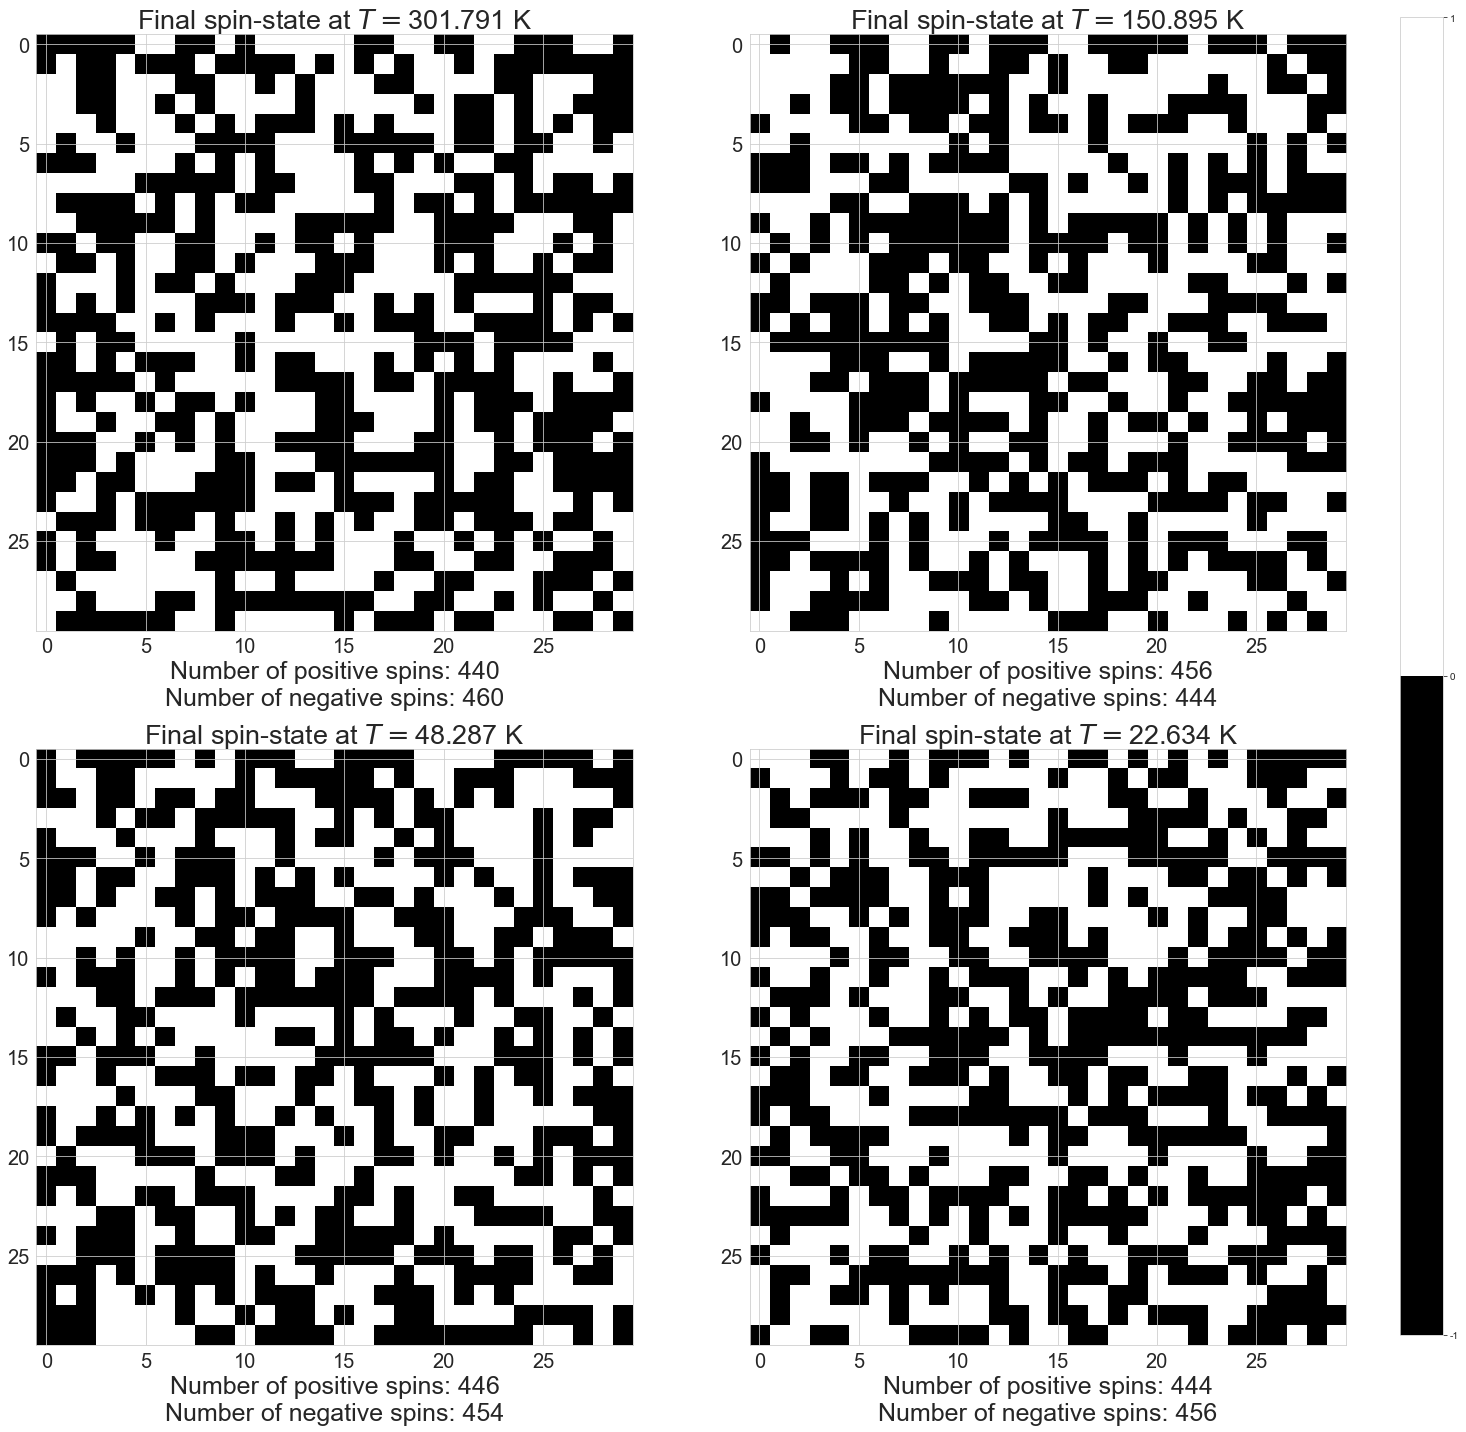

In [81]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0, nrows):
    for j in range(0, ncols):
        
        spin_image = axes[i][j].imshow(Spins_2D_dict[str(i*ncols + j + 1)], cmap='Greys_r')
        
        # The current positions of the spins
        Spins_positive_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]>0]
        Spins_negative_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]<0]
        
        axes[i][j].set_title('Final spin-state at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)
        
        axes[i][j].set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                                    len(Spins_negative_2D)),
                        fontsize=axislabelsize)
        
        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)

fig.tight_layout()

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([1, 0.07, 0.03, 0.915])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.savefig(image_path +
            'spin_states_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

In [50]:
#np.save('spinstate_2D.npy', spin_changes_chronology_2D['1']);

## Energy propagation of the system

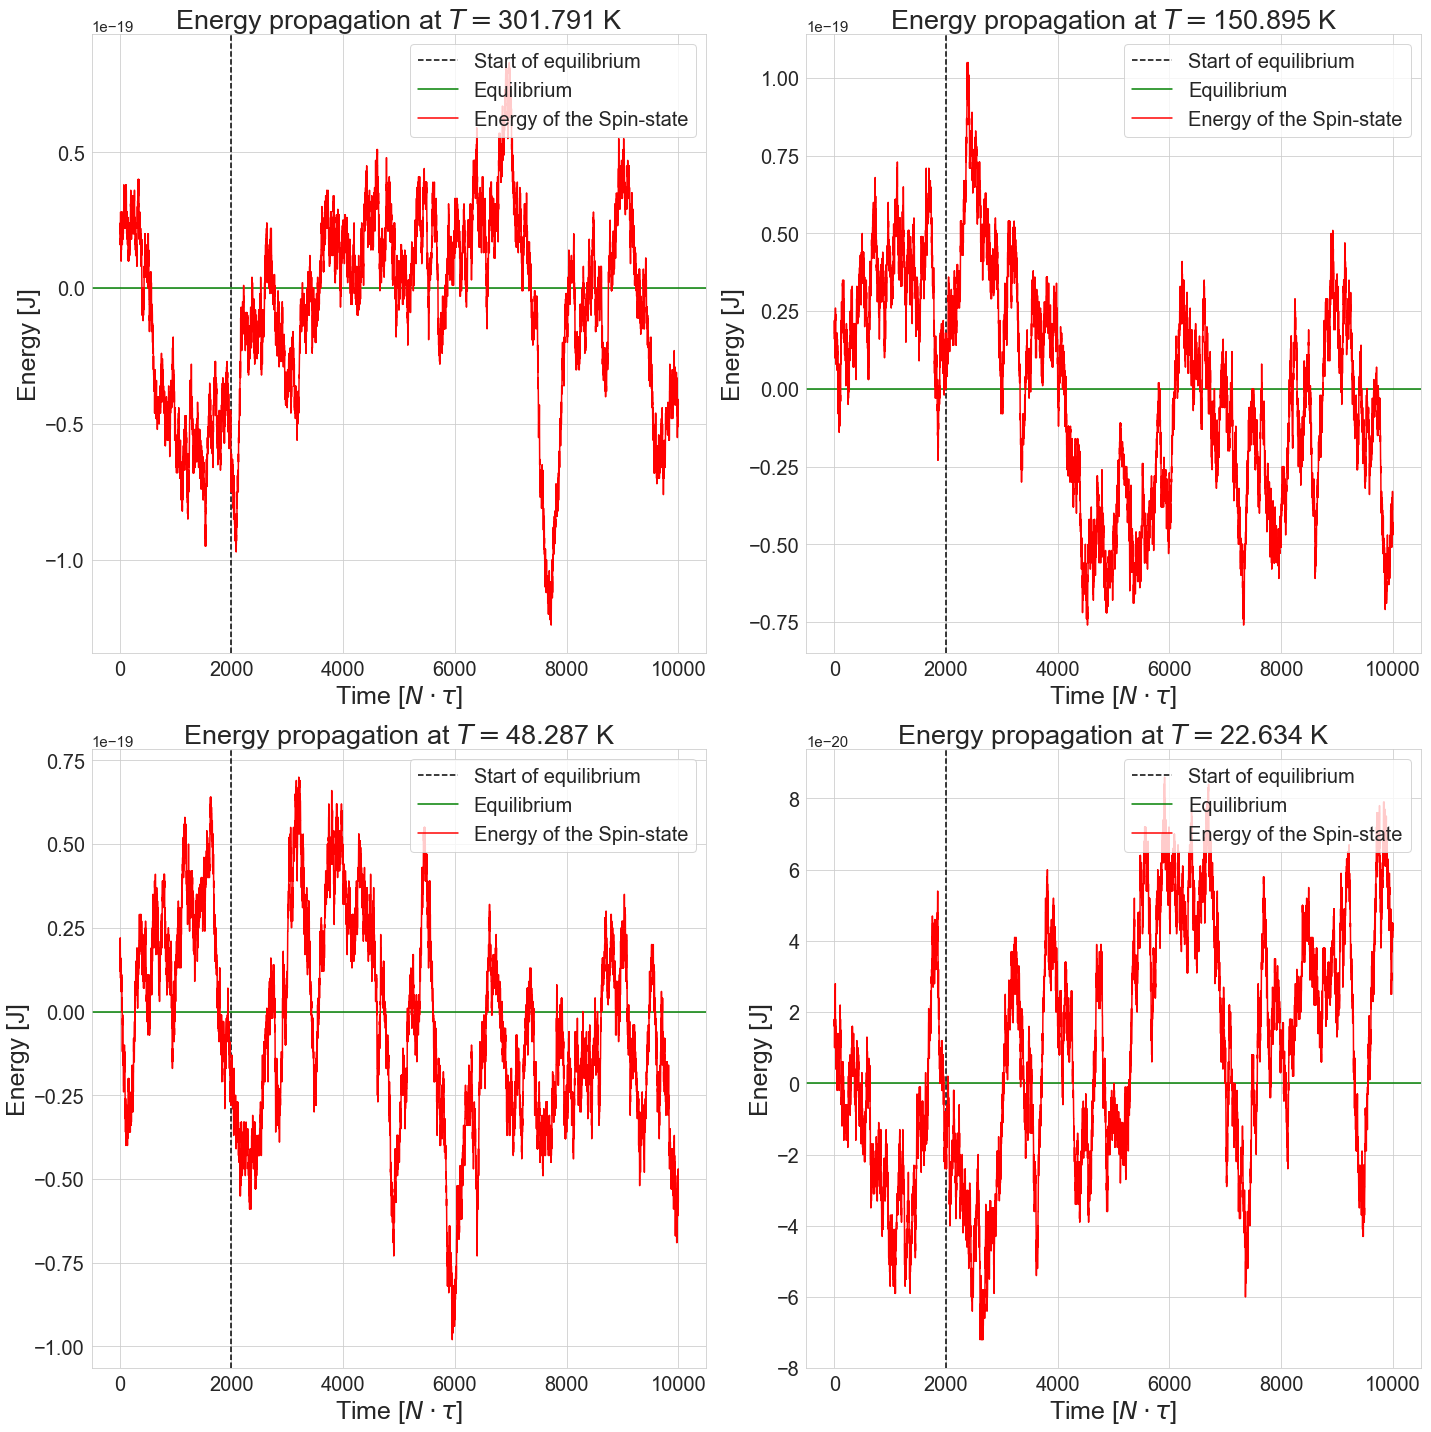

In [51]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, energy_chronology_2D[str(i*nrows + j + 1)], c='red', label='Energy of the Spin-state')

        axes[i][j].set_title('Energy propagation at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Energy [J]', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'discrete_energies_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Magnetization of the system
### 1./a Time evolution of magnetization

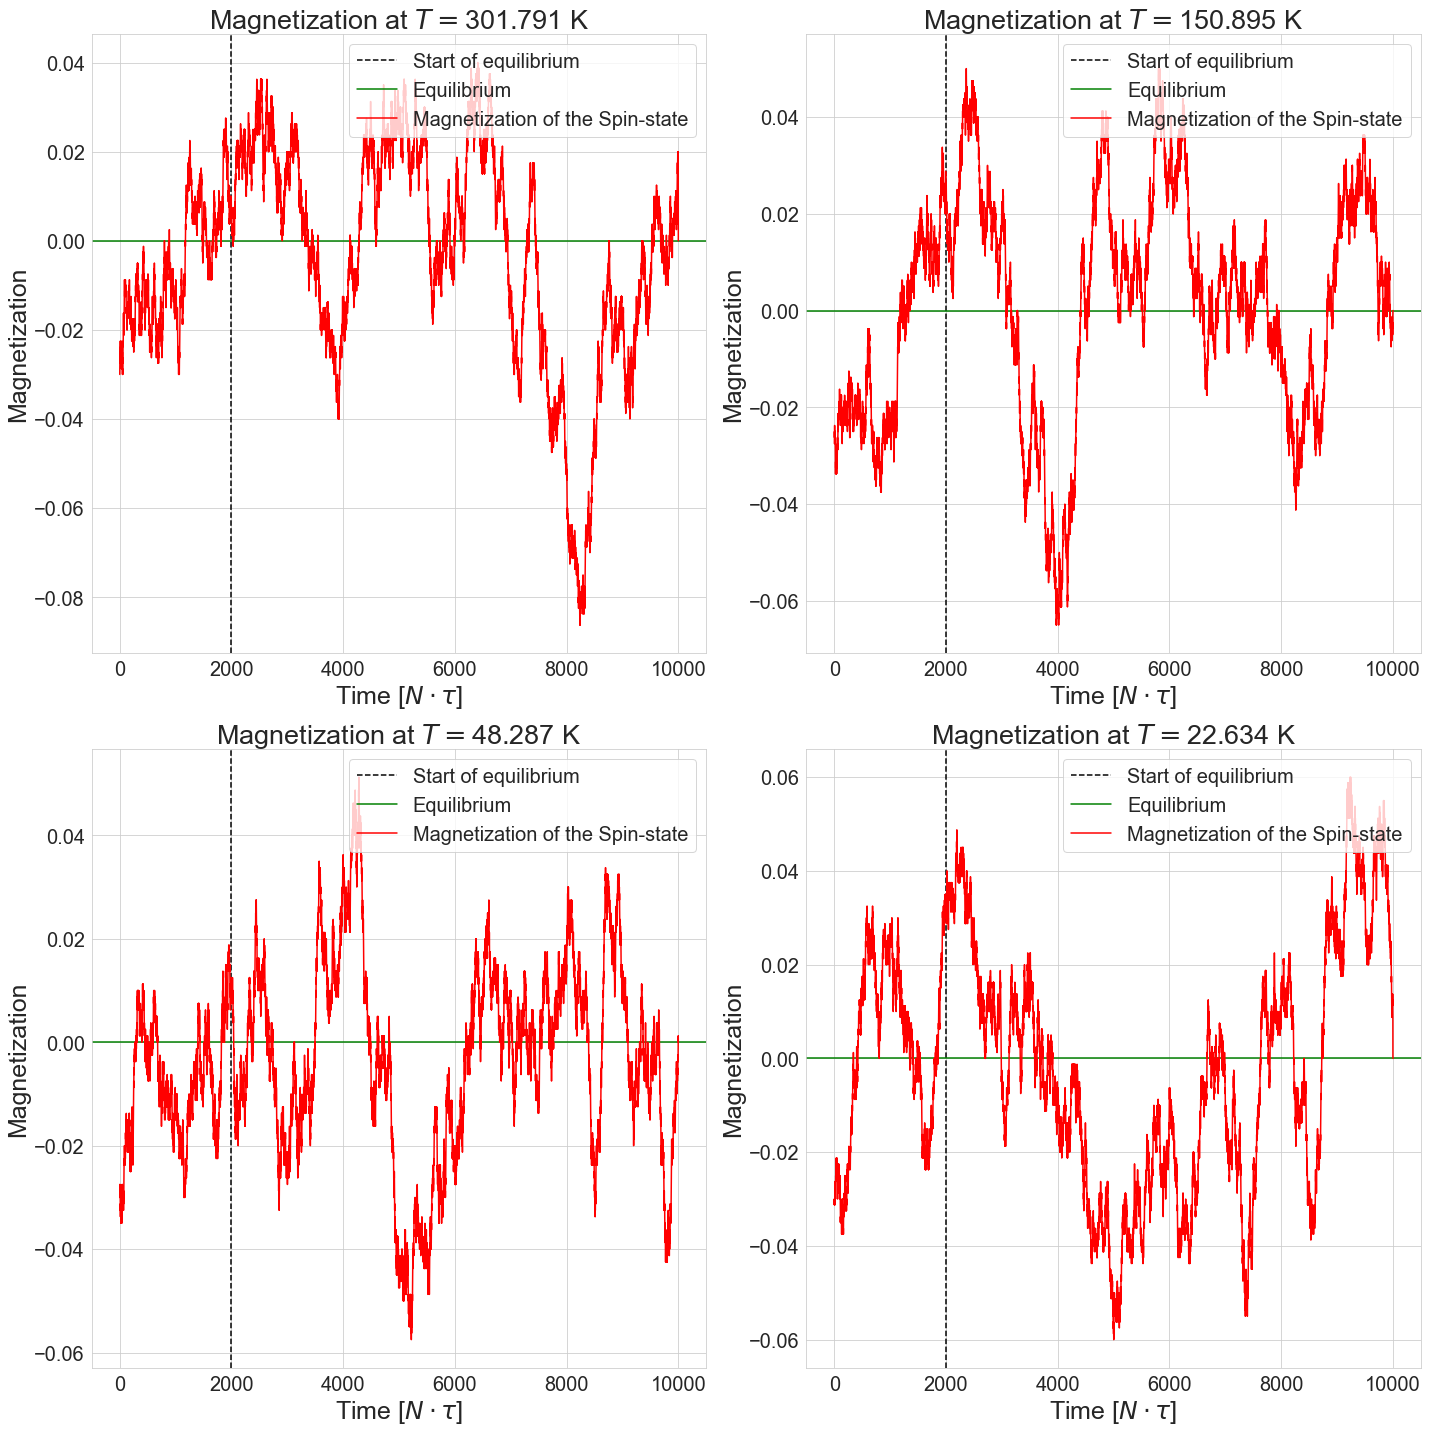

In [52]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./b Zoomed on fluctuations of magnetization

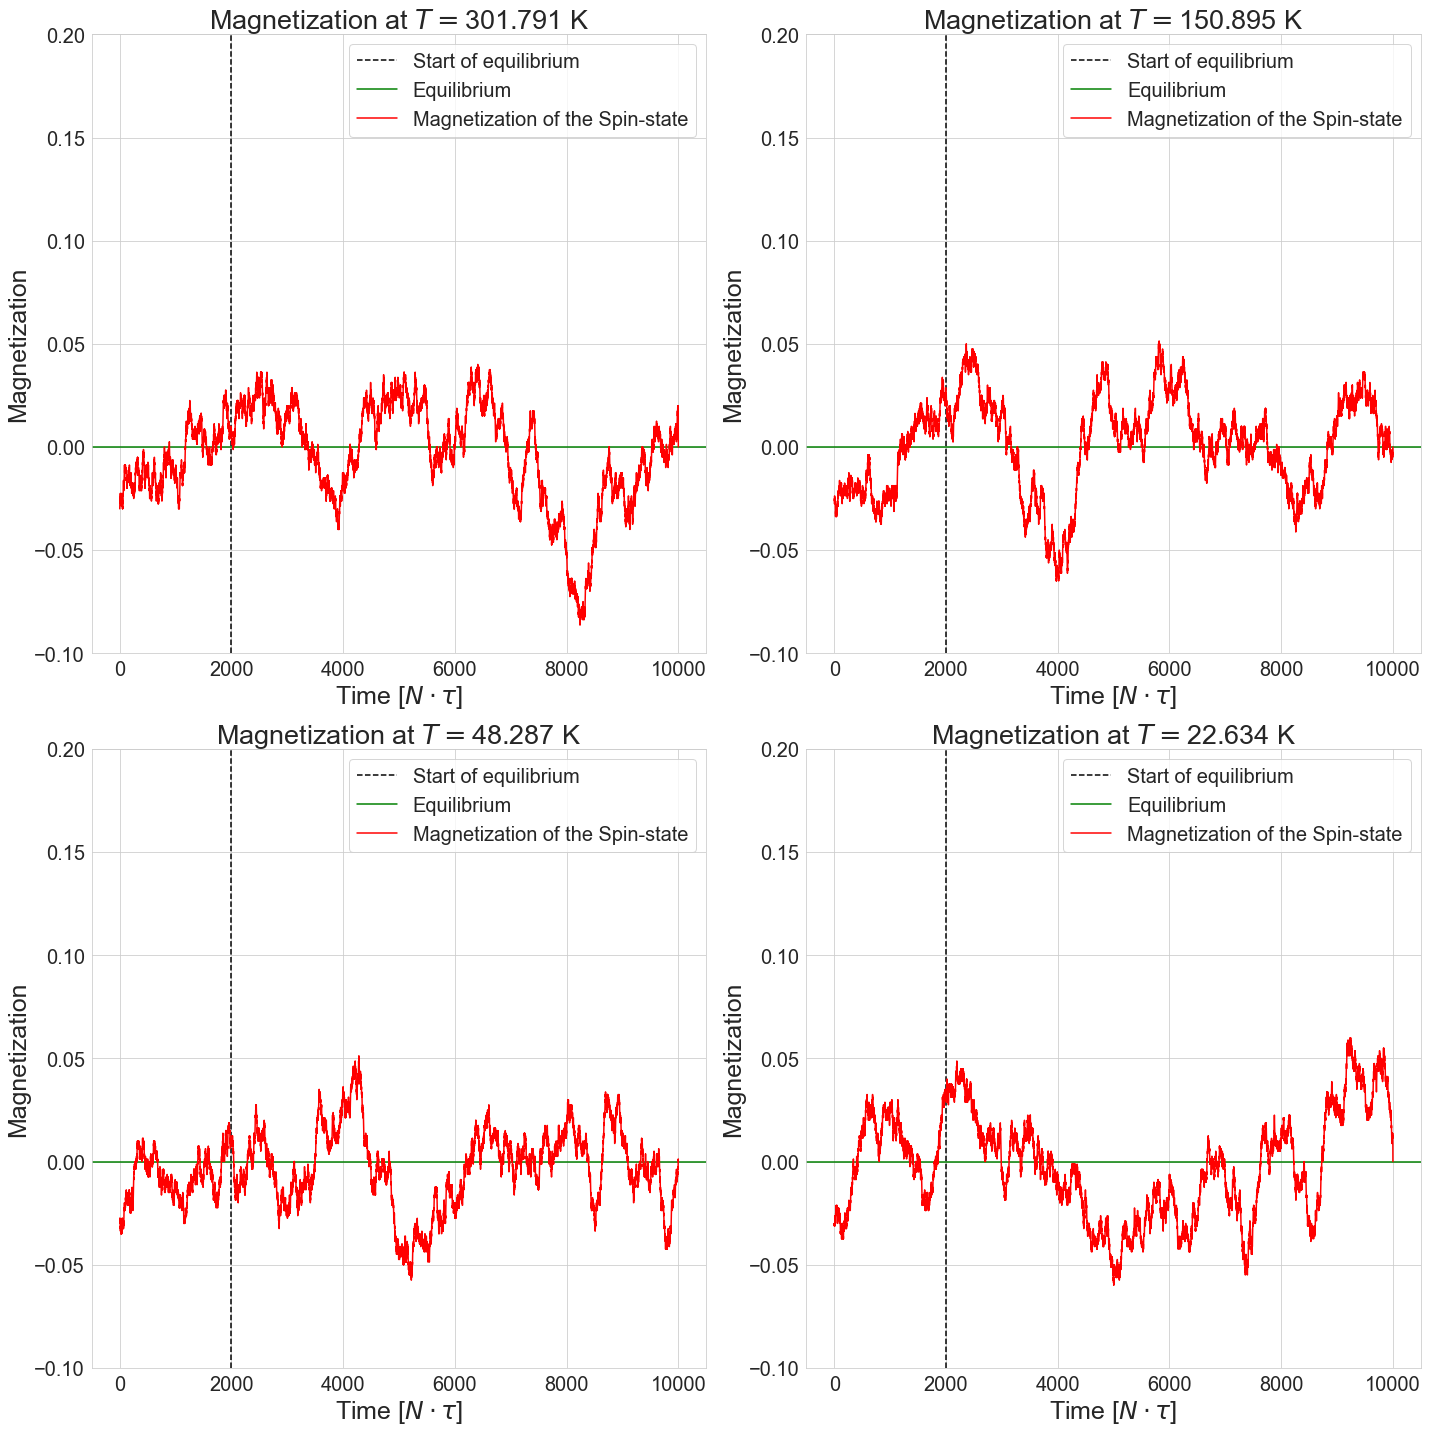

In [53]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.1, top=0.2)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./c Calculating $<m>$ expected value

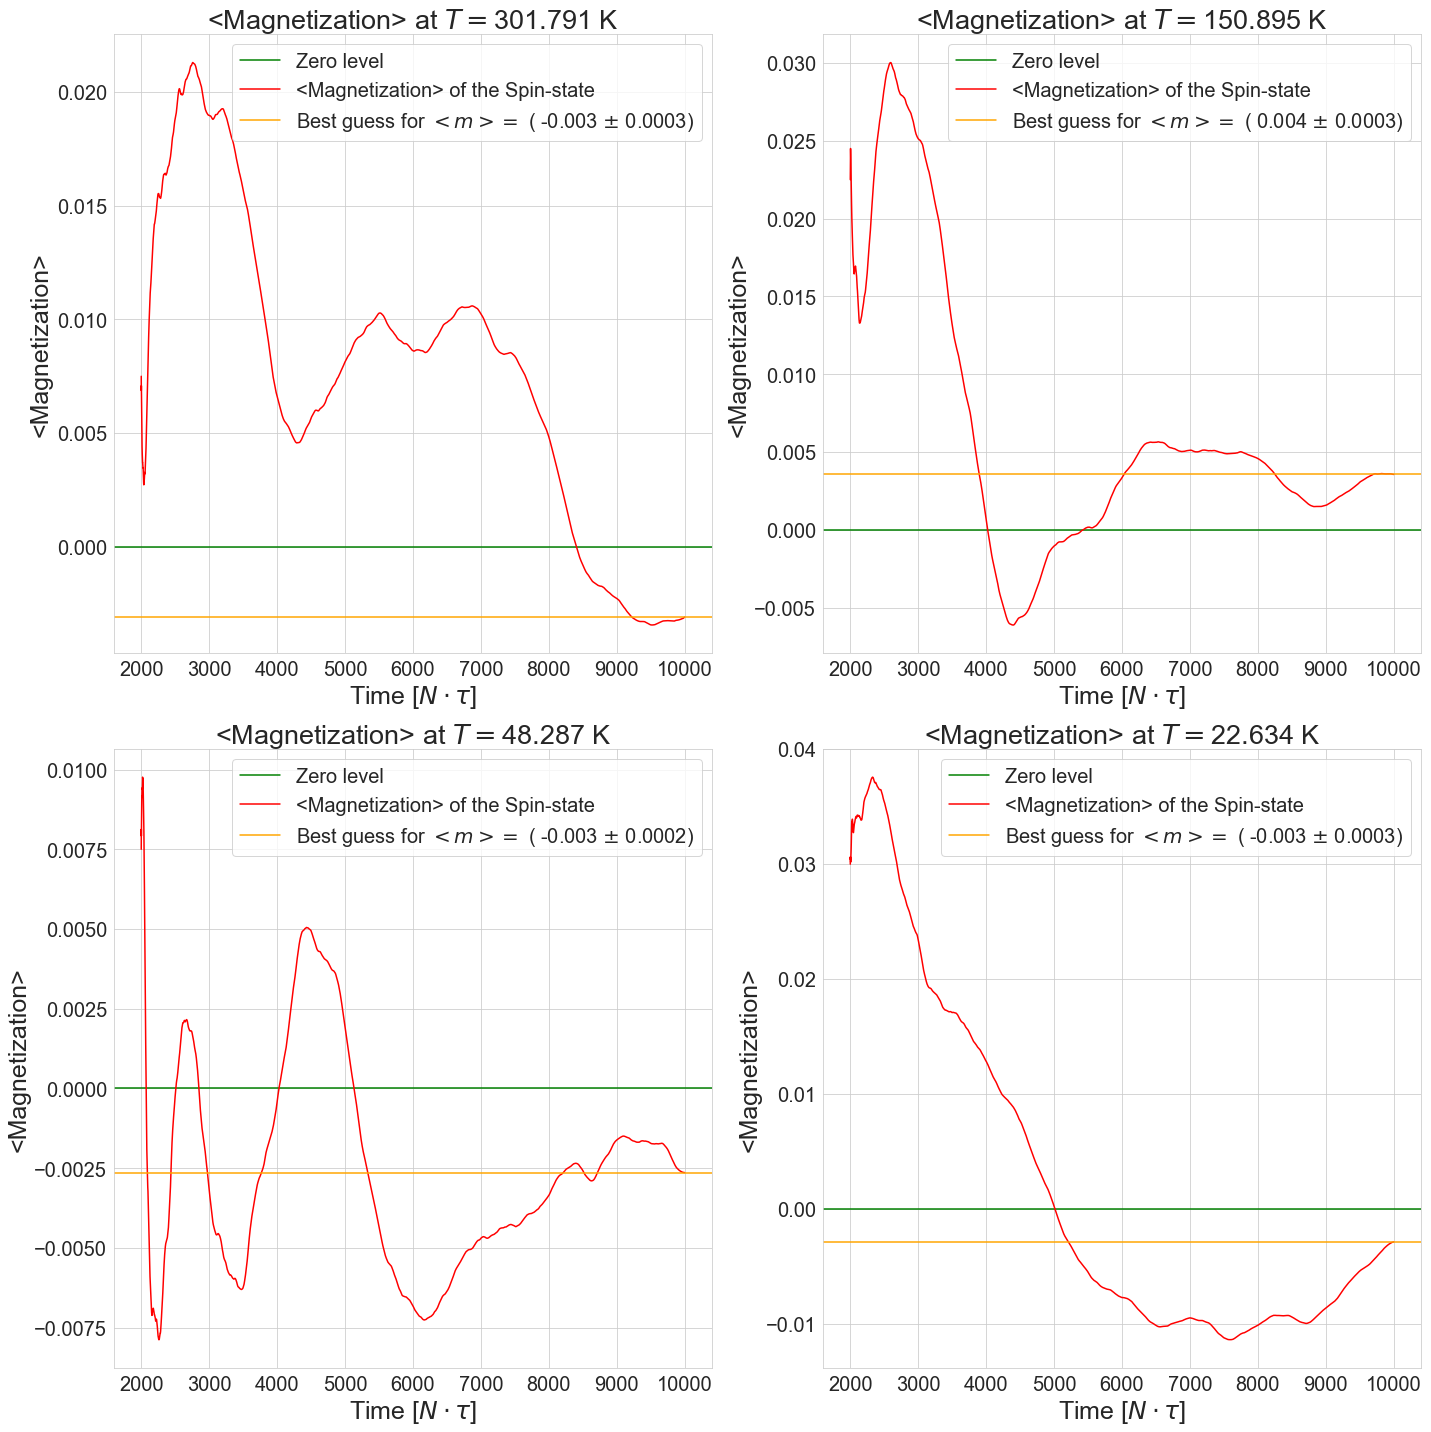

In [54]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_mean_2D = [total_magnetization_2D[str(i*nrows + j + 1)][start_offset_2D:k].mean()
                                 for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])/
                             np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_mean_2D, c='red', label='<Magnetization> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_mean_2D[-1], label='Best guess for $<m> =$ ( {0:.3f} $\pm$ {1:.4f})'.format(magnetization_mean_2D[-1],
                                                                                                                       standard_error_2D),
                           color='orange')

        axes[i][j].set_title('<Magnetization> at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Square of magnetization of the system
### 2./a Time evolution of the square of magnetization

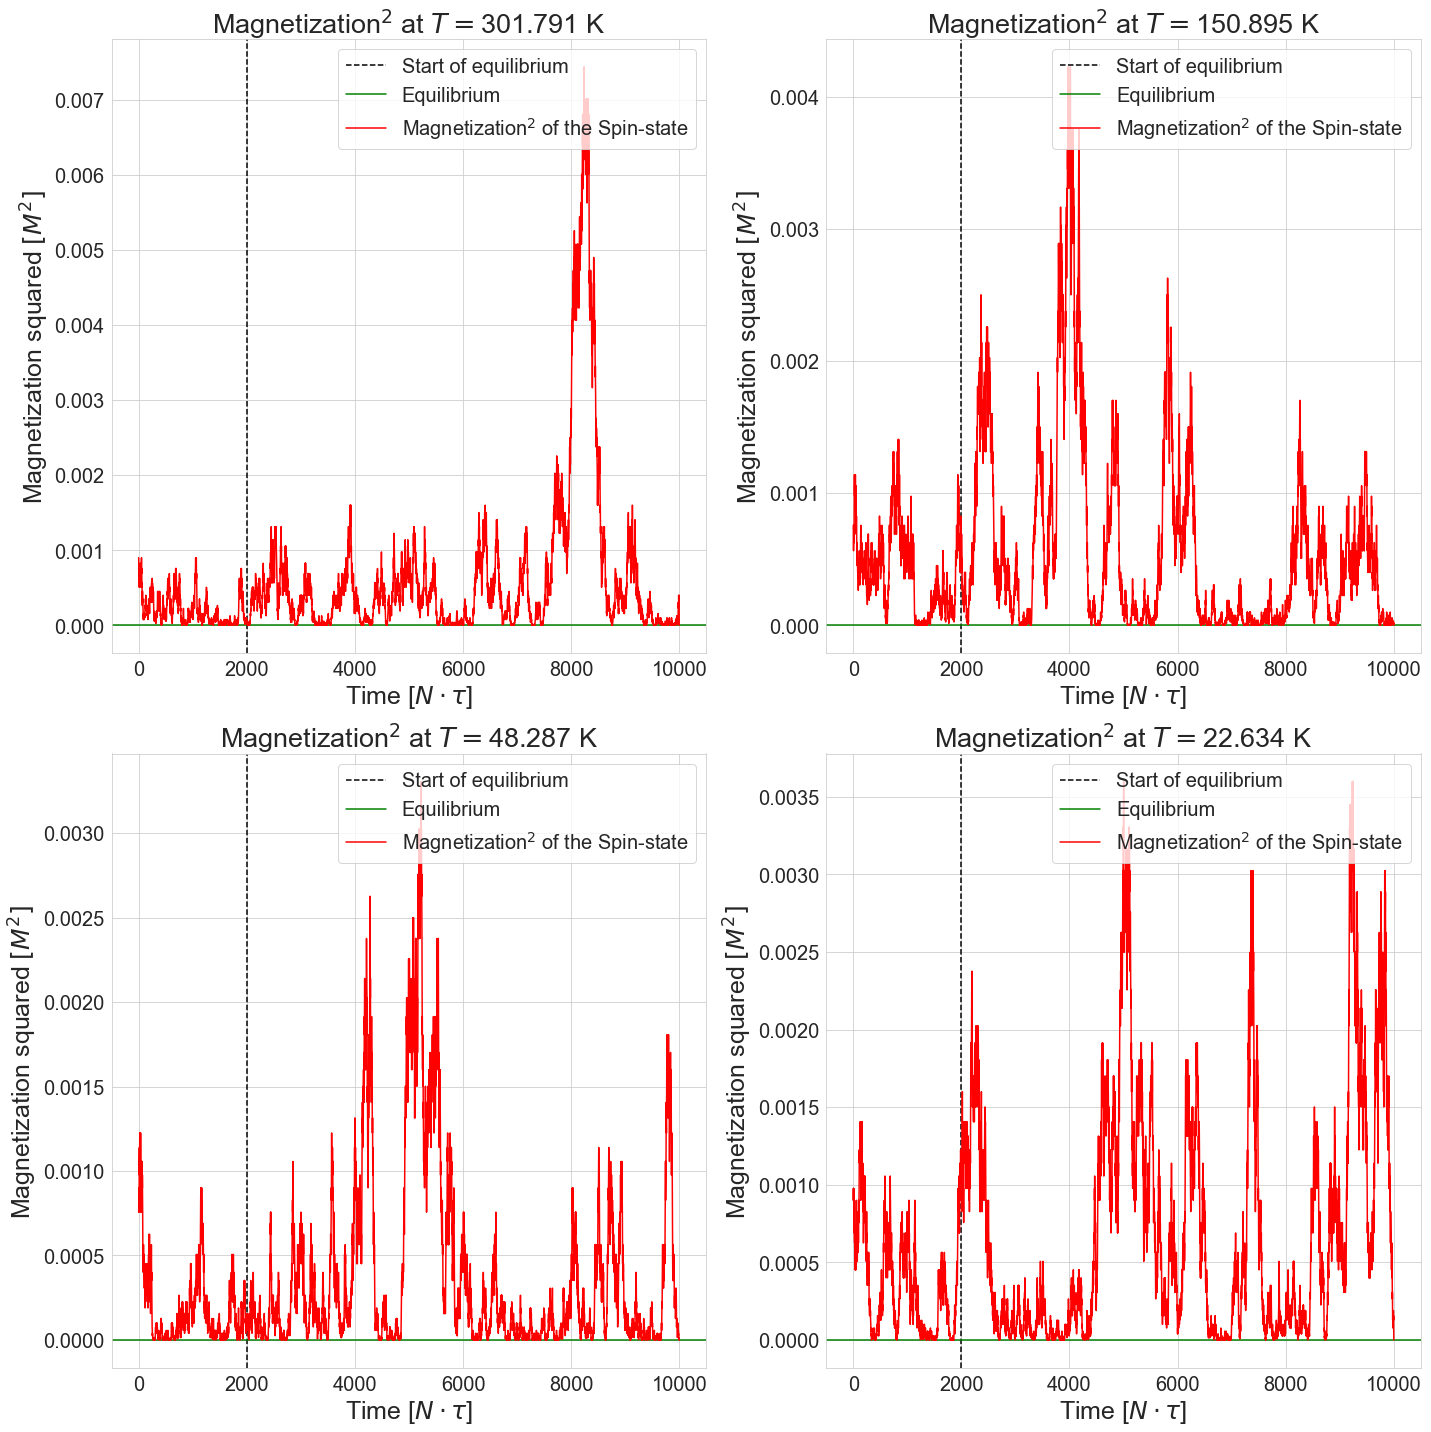

In [55]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)]**2, c='red',
                        label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./b Zoomed on fluctuations of the square of magnetization

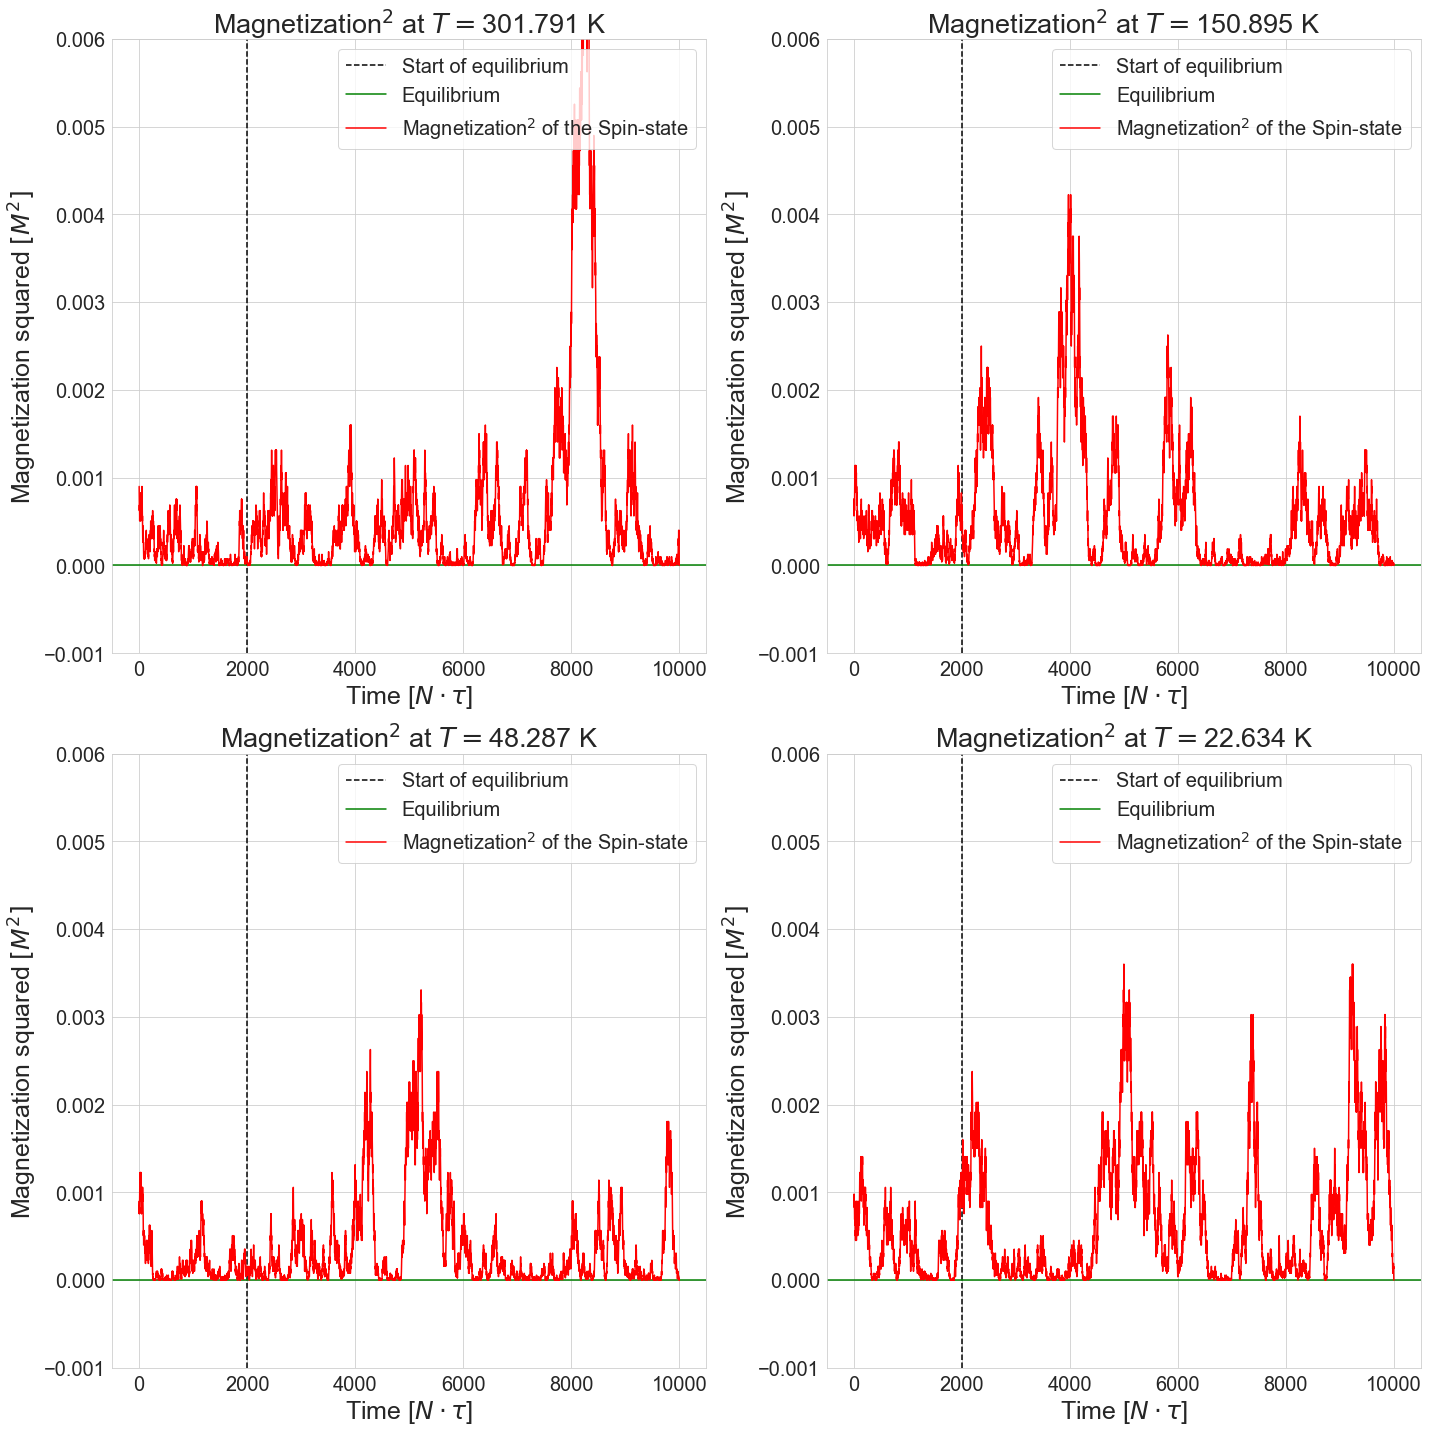

In [56]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)]**2, c='red',
                        label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.001, top=0.006)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./c Calculating $<m^{2}>$ expected value

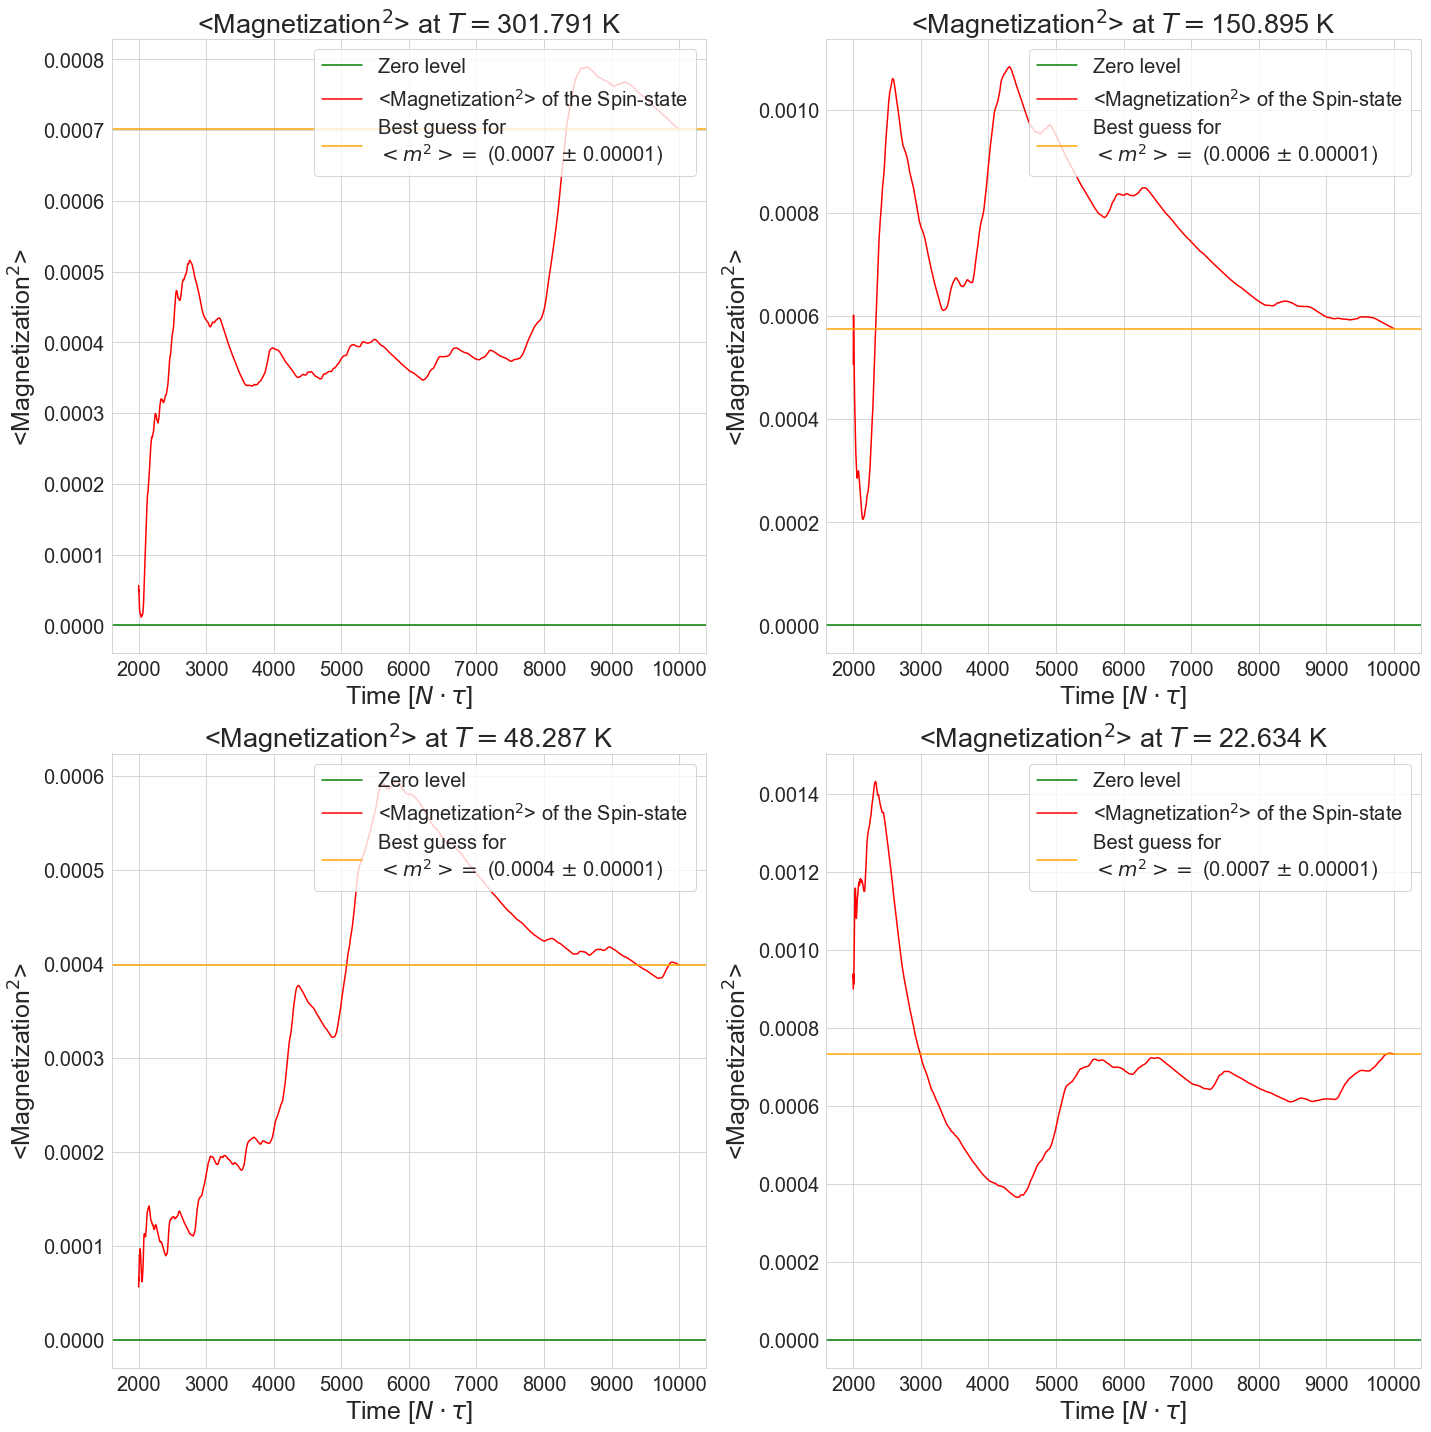

In [57]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_squared_mean_2D = [(total_magnetization_2D[str(i*nrows + j + 1)]**2)[start_offset_2D:k].mean()
                                      for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_squared_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)/
                                     np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_squared_mean_2D, c='red',
                        label='<Magnetization$^{2}$> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_squared_mean_2D[-1], label='Best guess for\n$<m^2> =$ ({0:.4f} $\pm$ {1:.5f})'.format(magnetization_squared_mean_2D[-1],
                                                                                                                                 standard_error_squared_2D),
                           color='orange')

        axes[i][j].set_title('<Magnetization$^2$> at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Calculating $<m^{2}> - <m>^{2} = \sigma^{2}$ variance

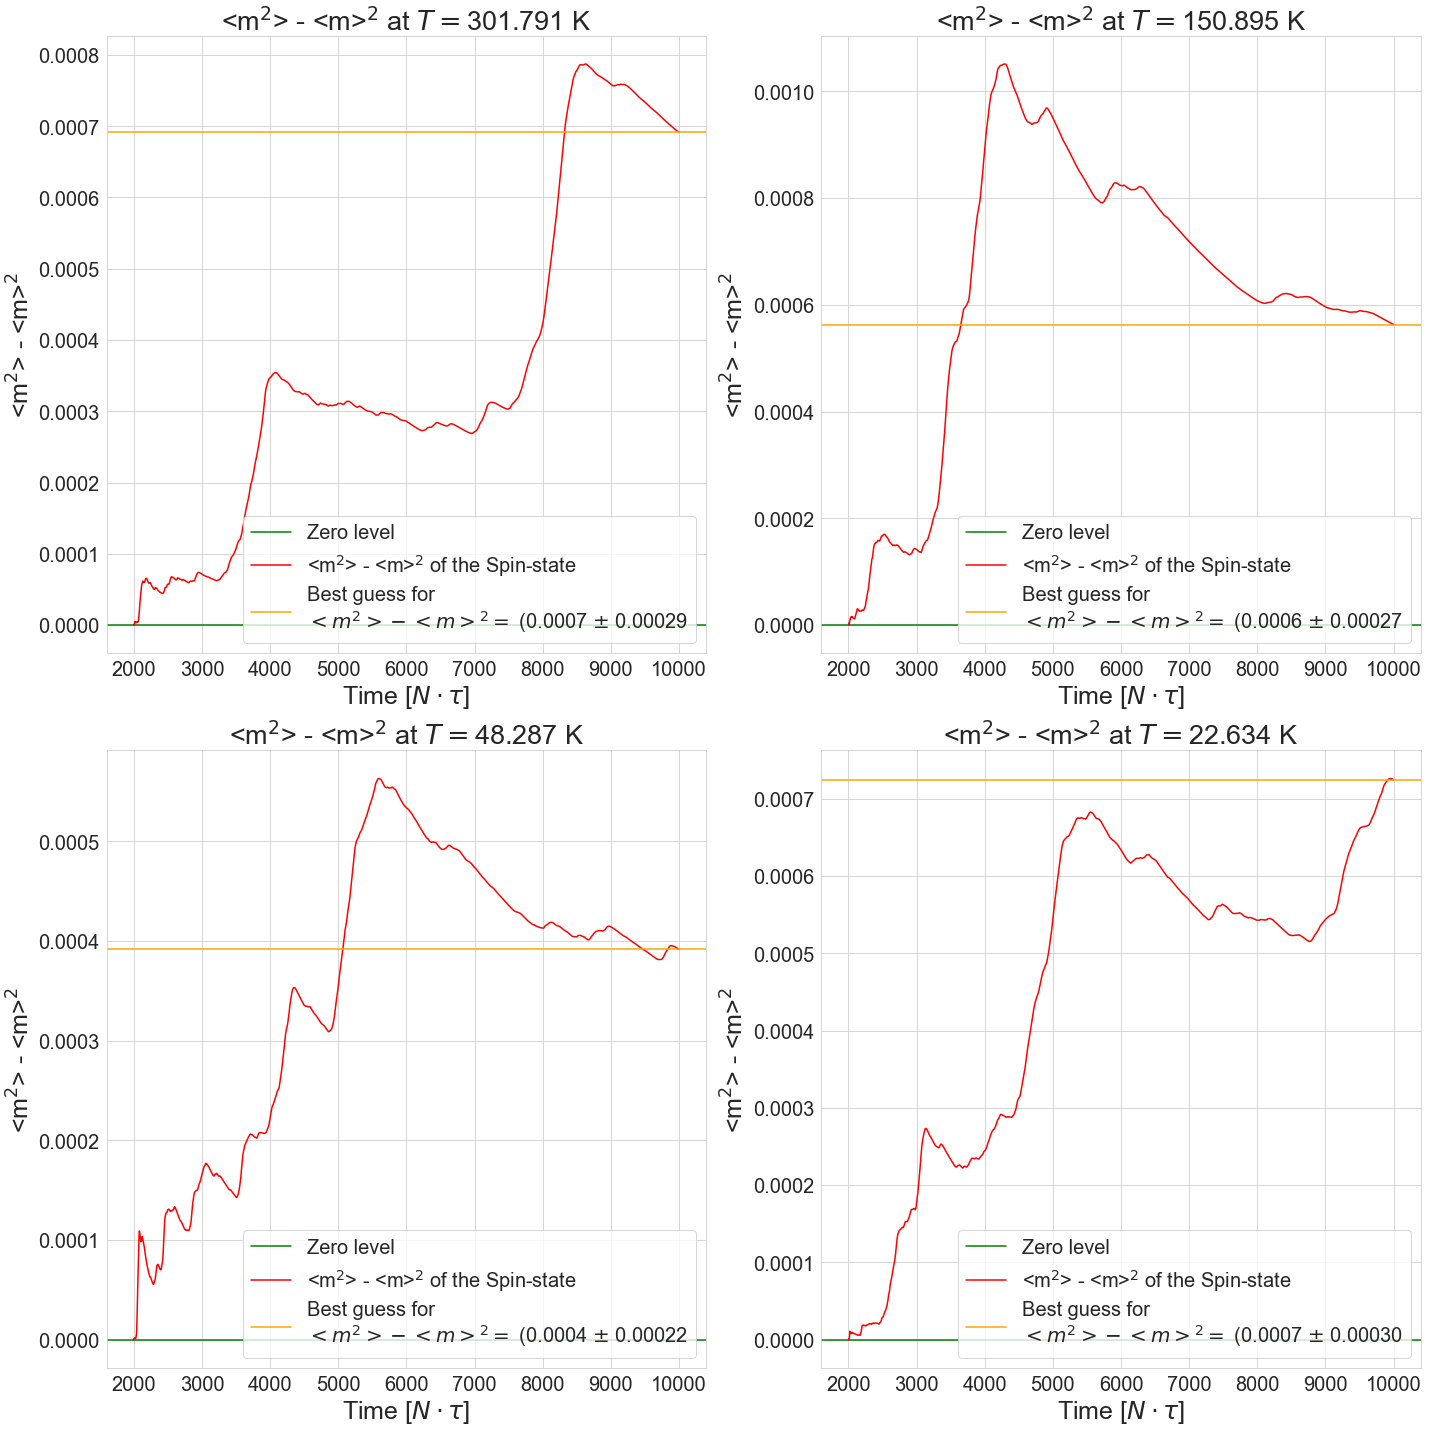

In [58]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_diff_mean_2D = [(total_magnetization_2D[str(i*nrows + j + 1)]**2)[start_offset_2D:k].mean() -
                                      total_magnetization_2D[str(i*nrows + j + 1)][start_offset_2D:k].mean()**2
                                       for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_squared_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)/
                                     np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)))
        
        standard_error_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])/
                             np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_diff_mean_2D, c='red',
                        label='<m$^2$> - <m>$^2$ of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_diff_mean_2D[-1], label='Best guess for\n$<m^2> - <m>^2 =$ ({0:.4f} $\pm$ {1:.5f}'.format(magnetization_diff_mean_2D[-1],
                                                                                                                                     np.sqrt(standard_error_squared_2D**2 + standard_error_2D**2)),
                           color='orange')

        axes[i][j].set_title('<m$^2$> - <m>$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<m$^2$> - <m>$^2$', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='lower right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_diff_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Fitting magnetizations
Testing theoretical model if mean magnetization is exponentially decreasing over time
> Only works if offset_2D = 0 !!

### Calculating $<m>$ expected value

In [170]:
if(start_offset_2D == 0):
    p0_fit_2D = {}
    x_fit_2D = {}
    y_fit_2D = {}
    popt_2D = {}
    pcov_2D = {}
    perr_2D = {}

    for i in range(0, len(betas)):
        magnetization_mean_2D = [total_magnetization_2D[str(i+1)][:k].mean()
                                 for k in range(1, steps_2D+1)]

        p0_fit_2D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_2D)

        x_fit_2D[str(i+1)] = step_indeces_2D[1:]
        y_fit_2D[str(i+1)] = magnetization_mean_2D
        popt_2D[str(i+1)], pcov_2D[str(i+1)] = curve_fit(fit_func,
                                                         x_fit_2D[str(i+1)],
                                                         y_fit_2D[str(i+1)],
                                                         p0=p0_fit_2D[str(i+1)])

        perr_2D[str(i+1)] = np.sqrt(np.diag(pcov_2D[str(i+1)]))

In [171]:
if(start_offset_2D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_mean_2D = [(total_magnetization_2D[str(i*ncols + j + 1)])[:k].mean()
                                     for k in range(1, steps_2D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_2D[1:], magnetization_mean_2D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_2D[1:], fit_func(x_fit_2D[str(i*ncols + j + 1)], *popt_2D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_fitted_2D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [172]:
if(start_offset_2D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_2D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_2D[str(i+1)][2]))

### Calculating $<m^{2}>$ expected value

In [173]:
if(start_offset_2D == 0):
    p0_fit_square_2D = {}
    x_fit_square_2D = {}
    y_fit_square_2D = {}
    popt_square_2D = {}
    pcov_square_2D = {}
    perr_square_2D = {}

    for i in range(0, len(betas)):
        magnetization_mean_2D = [(total_magnetization_2D[str(i+1)]**2)[:k].mean()
                                 for k in range(1, steps_2D+1)]
        p0_fit_square_2D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_2D)

        x_fit_square_2D[str(i+1)] = step_indeces_2D[1:]
        y_fit_square_2D[str(i+1)] = magnetization_squared_mean_2D
        popt_square_2D[str(i+1)], pcov_square_2D[str(i+1)] = curve_fit(fit_func,
                                                                       x_fit_square_2D[str(i+1)],
                                                                       y_fit_square_2D[str(i+1)],
                                                                       p0=p0_fit_square_2D[str(i+1)])

        perr_square_2D[str(i+1)] = np.sqrt(np.diag(pcov_square_2D[str(i+1)]))

In [174]:
if(start_offset_2D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_squared_mean_2D = [(total_magnetization_2D[str(i*ncols + j + 1)]**2)[:k].mean()
                                             for k in range(1, steps_2D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_2D[1:], magnetization_squared_mean_2D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_2D[1:], fit_func(x_fit_square_2D[str(i*ncols + j + 1)], *popt_square_2D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_squared_fitted_2D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [175]:
if(start_offset_2D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_square_2D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m^2> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_square_2D[str(i+1)][2]))